In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# ========================================
# 1. Load Dataset
# ========================================
train = pd.read_csv("UNSW_NB15_training-set.csv")
test  = pd.read_csv("UNSW_NB15_testing-set.csv")
data = pd.concat([train, test], axis=0, ignore_index=True)

print("Original dataset shape:", data.shape)
print("Normal vs Attack count:\n", data["label"].value_counts())

Original dataset shape: (257673, 45)
Normal vs Attack count:
 label
1    164673
0     93000
Name: count, dtype: int64


In [7]:
# ========================================
# 2. Balance dataset (Downsample attacks)
# ========================================
normal_df = data[data["label"] == 0]
attack_df = data[data["label"] == 1]

attack_sample = attack_df.sample(len(normal_df), random_state=42)
balanced_df = pd.concat([normal_df, attack_sample], axis=0).reset_index(drop=True)

print("\nBalanced shape:", balanced_df.shape)
print("Balanced counts:\n", balanced_df["label"].value_counts())


Balanced shape: (186000, 45)
Balanced counts:
 label
0    93000
1    93000
Name: count, dtype: int64


In [8]:
# ========================================
# 3. Feature Selection & Preprocessing
# ========================================
X = balanced_df.drop(columns=["label", "id"], errors="ignore")
y = balanced_df["label"]

# Encode categorical features
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# ----------------------------------------------------
# 4. Dimensionality Reduction with PCA
# ----------------------------------------------------
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("\nExplained variance ratio by PCA (first 10 components):")
print(pca.explained_variance_ratio_)


Explained variance ratio by PCA (first 10 components):
[0.22014268 0.09470251 0.08862556 0.07208376 0.06084803 0.054668
 0.0470214  0.04513018 0.03802489 0.0322538  0.02681206 0.02339827
 0.01948818 0.01900721 0.01670911 0.01595894 0.01536071 0.01395982
 0.01359732 0.00917124 0.00864965 0.0086154  0.00750855]


In [12]:
# ========================================
# 4. Apply K-Means
# ========================================
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)
balanced_df["cluster"] = clusters

In [13]:
# ----------------------------------------------------
# 6. Assign anomaly = smaller cluster
# ----------------------------------------------------
cluster_sizes = pd.Series(clusters).value_counts()
anomaly_cluster = cluster_sizes.idxmin()
balanced_df["pred_anomaly"] = (balanced_df["cluster"] == anomaly_cluster).astype(int)


Classification Report (1=Attack, 0=Normal):
              precision    recall  f1-score   support

           0       0.71      0.86      0.78     93000
           1       0.83      0.65      0.73     93000

    accuracy                           0.76    186000
   macro avg       0.77      0.76      0.76    186000
weighted avg       0.77      0.76      0.76    186000

Accuracy: 75.80%


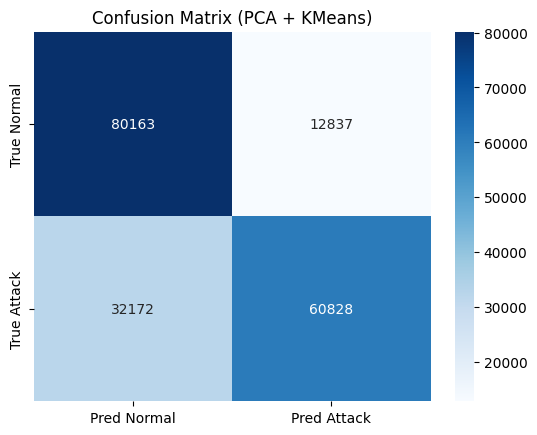

In [14]:
# ----------------------------------------------------
# 7. Evaluation
# ----------------------------------------------------
print("\nClassification Report (1=Attack, 0=Normal):")
print(classification_report(y, balanced_df["pred_anomaly"]))

accuracy = accuracy_score(y, balanced_df["pred_anomaly"])
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Confusion Matrix
cm = confusion_matrix(y, balanced_df["pred_anomaly"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Attack"],
            yticklabels=["True Normal", "True Attack"])
plt.title("Confusion Matrix (PCA + KMeans)")
plt.show()

In [34]:
X_reconstructed = pca.inverse_transform(pca.transform(X_scaled))

# Mean Squared Error (MSE)
mse = mean_squared_error(X_scaled, X_reconstructed)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(X_scaled, X_reconstructed)

print(" PCA Reconstruction Error Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

 PCA Reconstruction Error Metrics:
Mean Squared Error (MSE): 0.2464991975763119
Mean Absolute Error (MAE): 0.22446756818663233


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


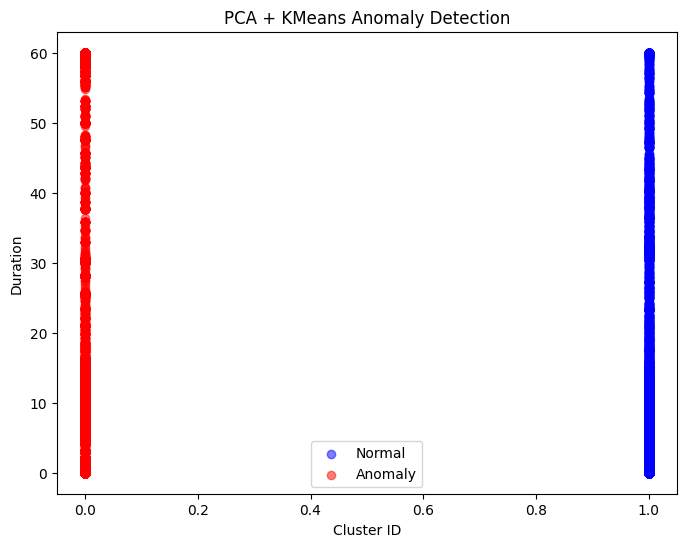

In [31]:
# ----------------------------------------------------
# 8. Visualization (PCA 2D scatter)
# ----------------------------------------------------
plt.figure(figsize=(8,6))
normal = balanced_df[balanced_df["pred_anomaly"]==0]
anomaly = balanced_df[balanced_df["pred_anomaly"]==1]

plt.scatter(normal["cluster"], normal["dur"], c="blue", label="Normal", alpha=0.5)
plt.scatter(anomaly["cluster"], anomaly["dur"], c="red", label="Anomaly", alpha=0.5)
plt.xlabel("Cluster ID")
plt.ylabel("Duration")
plt.legend()
plt.title("PCA + KMeans Anomaly Detection")
plt.show()

# **Training**

Original dataset shape: (257673, 45)
Normal vs Attack count:
 label
1    164673
0     93000
Name: count, dtype: int64

Balanced shape: (186000, 45)
Balanced counts:
 label
0    93000
1    93000
Name: count, dtype: int64

Number of PCA components: 2
Explained variance ratio sum: 0.3148451909106024

Classification Report (1=Attack, 0=Normal):
              precision    recall  f1-score   support

           0       0.72      0.88      0.79     93000
           1       0.84      0.65      0.73     93000

    accuracy                           0.76    186000
   macro avg       0.78      0.76      0.76    186000
weighted avg       0.78      0.76      0.76    186000

Accuracy: 76.42%


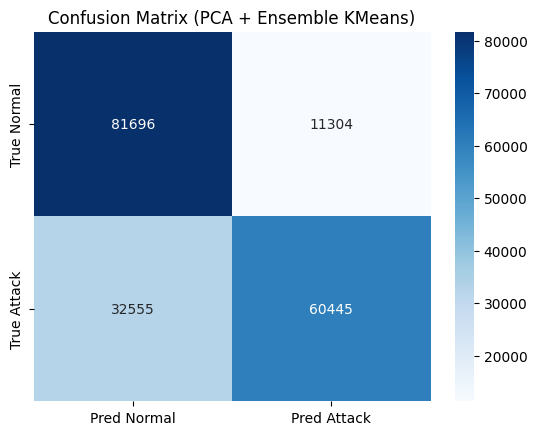

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================
# 1. Load Dataset
# ========================================
train = pd.read_csv("UNSW_NB15_training-set.csv")
print("Original dataset shape:", data.shape)
print("Normal vs Attack count:\n", data["label"].value_counts())

# ========================================
# 2. Balance dataset (Downsample attacks)
# ========================================
normal_df = data[data["label"] == 0]
attack_df = data[data["label"] == 1]
attack_sample = attack_df.sample(len(normal_df), random_state=42)
balanced_df = pd.concat([normal_df, attack_sample], axis=0).reset_index(drop=True)
print("\nBalanced shape:", balanced_df.shape)
print("Balanced counts:\n", balanced_df["label"].value_counts())

# ========================================
# 3. Feature Selection & Preprocessing
# ========================================
X = balanced_df.drop(columns=["label", "id"], errors="ignore")
y = balanced_df["label"]

# Encode categorical features
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========================================
# 4. PCA
# ========================================
pca = PCA(n_components=0.25, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("\nNumber of PCA components:", X_pca.shape[1])
print("Explained variance ratio sum:", pca.explained_variance_ratio_.sum())

# ========================================
# 5. Ensemble KMeans (Smaller cluster = anomaly)
# ========================================
n_runs = 5
ensemble_clusters = np.zeros((X_pca.shape[0], n_runs))

for i in range(n_runs):
    kmeans = KMeans(n_clusters=2, random_state=42+i, n_init=20)
    clusters = kmeans.fit_predict(X_pca)
    ensemble_clusters[:, i] = clusters

# Determine anomaly cluster for each run (smaller cluster)
pred_anomalies = np.zeros(X_pca.shape[0])
for i in range(n_runs):
    cluster_sizes = pd.Series(ensemble_clusters[:, i]).value_counts()
    anomaly_cluster = cluster_sizes.idxmin()
    pred_anomalies += (ensemble_clusters[:, i] == anomaly_cluster).astype(int)

# Majority vote across ensemble
balanced_df["pred_anomaly"] = (pred_anomalies >= (n_runs/2)).astype(int)

# ========================================
# 6. Evaluation
# ========================================
print("\nClassification Report (1=Attack, 0=Normal):")
print(classification_report(y, balanced_df["pred_anomaly"]))
accuracy = accuracy_score(y, balanced_df["pred_anomaly"])
print("Accuracy: {:.2f}%".format(accuracy*100))

# Confusion Matrix
cm = confusion_matrix(y, balanced_df["pred_anomaly"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Attack"],
            yticklabels=["True Normal", "True Attack"])
plt.title("Confusion Matrix (PCA + Ensemble KMeans)")
plt.show()

# **Testing**

Test dataset shape: (175341, 45)
Normal vs Attack counts:
 label
1    119341
0     56000
Name: count, dtype: int64

Classification Report (1=Attack, 0=Normal):
              precision    recall  f1-score   support

           0       0.55      0.93      0.69     56000
           1       0.95      0.64      0.76    119341

    accuracy                           0.73    175341
   macro avg       0.75      0.78      0.73    175341
weighted avg       0.82      0.73      0.74    175341

Accuracy: 73.11%


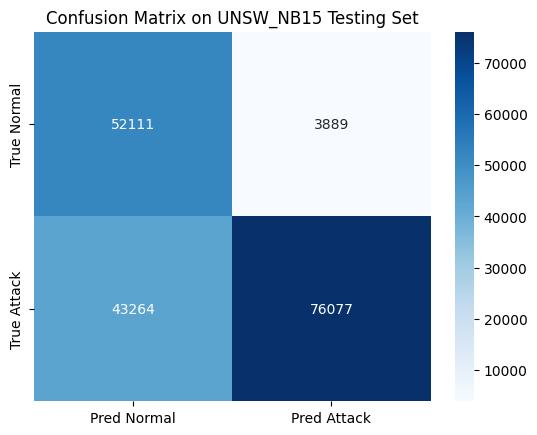

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ========================================
# 1. Load Testing Dataset
# ========================================
test_data = pd.read_csv("UNSW_NB15_testing-set.csv")
print("Test dataset shape:", test_data.shape)
print("Normal vs Attack counts:\n", test_data["label"].value_counts())

# ========================================
# 2. Preprocess Features
# ========================================
X_test = test_data.drop(columns=["label", "id"], errors="ignore")

# Encode categorical features
for col in X_test.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col].astype(str))

# Scale features using the scaler from training
X_test_scaled = scaler.transform(X_test)  # 'scaler' from training

# ========================================
# 3. PCA Transformation
# ========================================
X_test_pca = pca.transform(X_test_scaled)  # 'pca' from training

# ========================================
# 4. Predict using Ensemble KMeans
# ========================================
n_runs = 5  # same as training
ensemble_clusters_test = np.zeros((X_test_pca.shape[0], n_runs))

for i in range(n_runs):
    kmeans = KMeans(n_clusters=2, random_state=42+i, n_init=20)
    kmeans.fit(X_pca)  # fit on training PCA data
    clusters = kmeans.predict(X_test_pca)
    ensemble_clusters_test[:, i] = clusters

# Assign anomaly based on smaller cluster for each run
pred_anomalies_test = np.zeros(X_test_pca.shape[0])
for i in range(n_runs):
    cluster_sizes = pd.Series(ensemble_clusters_test[:, i]).value_counts()
    anomaly_cluster = cluster_sizes.idxmin()
    pred_anomalies_test += (ensemble_clusters_test[:, i] == anomaly_cluster).astype(int)

# Majority vote
test_data["pred_anomaly"] = (pred_anomalies_test >= (n_runs/2)).astype(int)

# ========================================
# 5. Evaluation
# ========================================
print("\nClassification Report (1=Attack, 0=Normal):")
print(classification_report(test_data["label"], test_data["pred_anomaly"]))

accuracy = accuracy_score(test_data["label"], test_data["pred_anomaly"])
print("Accuracy: {:.2f}%".format(accuracy*100))

# Confusion Matrix
cm = confusion_matrix(test_data["label"], test_data["pred_anomaly"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Attack"],
            yticklabels=["True Normal", "True Attack"])
plt.title("Confusion Matrix on UNSW_NB15 Testing Set")
plt.show()

In [19]:
pip install joblib

In [36]:
import joblib

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save PCA
joblib.dump(pca, "pca.pkl")

# Save ensemble of KMeans
kmeans_models = []
for i in range(n_runs):
    kmeans = KMeans(n_clusters=2, random_state=42+i, n_init=20)
    kmeans.fit(X_pca)  # fit on training PCA data
    kmeans_models.append(kmeans)

joblib.dump(kmeans_models, "kmeans_ensemble.pkl")

['kmeans_ensemble.pkl']